In [7]:
! wget https://github.com/caserec/Datasets-for-Recommneder-Systems/raw/master/Processed%20Datasets/AmazonMusic.tar.xz
! tar -xf AmazonMusic.tar.xz
! pip install caserecommender

--2021-02-25 14:26:37--  https://github.com/caserec/Datasets-for-Recommneder-Systems/raw/master/Processed%20Datasets/AmazonMusic.tar.xz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/caserec/Datasets-for-Recommender-Systems/raw/master/Processed%20Datasets/AmazonMusic.tar.xz [following]
--2021-02-25 14:26:38--  https://github.com/caserec/Datasets-for-Recommender-Systems/raw/master/Processed%20Datasets/AmazonMusic.tar.xz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/caserec/Datasets-for-Recommender-Systems/master/Processed%20Datasets/AmazonMusic.tar.xz [following]
--2021-02-25 14:26:38--  https://raw.githubusercontent.com/caserec/Datasets-for-Recommender-Systems/master/Processed%20Datasets/AmazonMusic.tar.xz
Resolving raw.githubuserc

In [9]:
import pandas as pd
import numpy as np

In [11]:
dataset = pd.read_json('./AmazonMusic/Digital_Music_5.json', lines=True)
dataset.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5,Enya at her most elegant,991526400,"06 3, 2001"
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5,The best so far,1058140800,"07 14, 2003"
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5,Ireland produces good music.,957312000,"05 3, 2000"
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4,4.5; music to dream to,1200528000,"01 17, 2008"


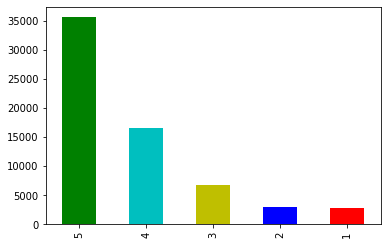

In [12]:
dataset.overall.value_counts().plot(kind='bar', color=['g', 'c', 'y', 'b', 'r']);

In [14]:
df_recsys = dataset[['reviewerID', 'asin', 'overall']] 
df_recsys.head()

,reviewerID,asin,overall
0,A3EBHHCZO6V2A4,5555991584,5
1,AZPWAXJG9OJXV,5555991584,5
2,A38IRL0X2T4DPF,5555991584,5
3,A22IK3I6U76GX0,5555991584,5
4,A1AISPOIIHTHXX,5555991584,4


In [13]:
dataset_metadata = pd.read_csv('AmazonMusic/amazon_music_metadata.csv')
dataset_metadata.head()

,asin,title,Accessories,Acid Jazz,Acoustic Blues,Adult Alternative,Adult Contemporary,Africa,Afro Brazilian,Afro-Cuban,Air Tool Accessories,Album-Oriented Rock (AOR),Alt Industrial,Alt-Country & Americana,Alternative Medicine,Alternative Metal,Alternative Rock,Ambient,Ambient Pop,American Alternative,American Punk,Americana,Amplifiers & Effects,Andes,Arena Rock,Argentina,Arts & Crafts Supplies,"Arts, Crafts & Sewing",Australia & New Zealand,Austria,Avant Garde & Free Jazz,Baby Products,Bachata,Bags & Cases,Bakersfield Sound,Ballets,Ballets & Dances,Baroque Pop,Bass,Bass Guitars,...,Third Wave Ska,Thrash & Speed Metal,Tin Pan Alley,Tools & Accessories,Tools & Home Improvement,Traditional,Traditional Blues,Traditional British & Celtic Folk,Traditional Folk,Traditional Jazz & Ragtime,Traditional Pop,Traditional Vocal Pop,Trance,Tributes,Trim & Embellishments,Trip-Hop,Turkey,Turntablists,Twee Pop,Urban & Contemporary,Urban Folk,Uruguay,Venezuela,Vitamins & Dietary Supplements,Vocal Blues,Vocal Jazz,Vocal Non-Opera,Vocal Pop,Voices,Walkers,Wall Stickers,Wall Switches,Washers,Wave Washers & Wave Springs,Wedding Music,West Coast,West Coast Blues,Western Swing,World Dance,World Music
0,5555991584,Memory of Trees,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6308051551,Dont Drink His Blood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7901622466,On Fire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B0000000ZW,Changing Faces,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,B00000016W,Pet Sounds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_recsys = df_recsys.merge(dataset_metadata[['asin', 'title']])
df_recsys.head()

,reviewerID,asin,overall,title
0,A3EBHHCZO6V2A4,5555991584,5,Memory of Trees
1,AZPWAXJG9OJXV,5555991584,5,Memory of Trees
2,A38IRL0X2T4DPF,5555991584,5,Memory of Trees
3,A22IK3I6U76GX0,5555991584,5,Memory of Trees
4,A1AISPOIIHTHXX,5555991584,4,Memory of Trees


In [18]:
# unique users and items
df_recsys.reviewerID.nunique(), df_recsys.asin.nunique()

(5148, 2582)

In [19]:
# map users and items
map_users = {user: u_id for u_id, user in enumerate(df_recsys.reviewerID.unique())}
map_items = {item: i_id for i_id, item in enumerate(df_recsys.asin.unique())}
df_recsys['asin'] = df_recsys['asin'].map(map_items)
df_recsys['reviewerID'] = df_recsys['reviewerID'].map(map_users)
df_recsys.head()

,reviewerID,asin,overall,title
0,0,0,5,Memory of Trees
1,1,0,5,Memory of Trees
2,2,0,5,Memory of Trees
3,3,0,5,Memory of Trees
4,4,0,4,Memory of Trees


map title

In [20]:
asin_title = {}

for idx, row in df_recsys.iterrows():
    asin_title[row['asin']] = row['title']
    
np.save('map_tilte.npy', asin_title)

metadata transformation

In [41]:
new_metadata = dataset_metadata.iloc[:,1:]
new_metadata = new_metadata.melt(id_vars=["title"])
new_metadata = new_metadata[new_metadata.value != 0]
new_metadata.reset_index(inplace=True, drop=True)
new_metadata.tail()

,title,variable,value
62572,Lloyd Im Ready to Be Heartbroken,World Music,1.0
62573,I Sincerely Apologize For All The Trouble Ive ...,World Music,1.0
62574,Faster Pussycat,World Music,1.0
62575,Eva Contro Eva,World Music,1.0
62576,Waters of Nazareth,World Music,1.0


In [42]:
dict_title = np.load('map_tilte.npy', allow_pickle=True).tolist()
inverse_dict_title = {value: int(key) for key, value in dict_title.items()}
new_metadata['asin_id'] = new_metadata['title'].map(inverse_dict_title)

new_metadata.dropna(inplace=True)
new_metadata = new_metadata[['asin_id', 'variable', 'value']]
# new_metadata = new_metadata.drop_duplicates()
new_metadata['asin_id'] = new_metadata.asin_id.astype(int)
new_metadata.to_csv('items_metadata.dat', index=False, sep='\t', header=False)
new_metadata.tail()

,asin_id,variable,value
62553,2541,World Music,1.0
62561,2550,World Music,1.0
62562,2555,World Music,1.0
62563,2555,World Music,1.0
62566,2562,World Music,1.0


divide dataset

In [22]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_recsys, test_size=0.33, random_state=42)

train.to_csv('train.dat', index=False, header=False, sep='\t')
test.to_csv('test.dat', index=False, header=False, sep='\t')

Rating prediction

In [23]:
from caserec.recommenders.rating_prediction.most_popular import MostPopular

MostPopular('train.dat', 'test.dat', 'rp_mostPopular.dat').compute()

[Case Recommender: Rating Prediction > Most Popular]

train data:: 5036 users and 2581 items (34703 interactions) | sparsity:: 99.73%
test data:: 4508 users and 2493 items (17093 interactions) | sparsity:: 99.85%

prediction_time:: 0.299216 sec


Eval:: MAE: 0.744015 RMSE: 1.005638 


In [24]:
predictions = pd.read_csv('rp_mostPopular.dat', sep='\t', names=['reviewerID', 'asin', 'rate'])
predictions['title'] = predictions.asin.map(asin_title)
predictions.head()

,reviewerID,asin,rate,title
0,0,2471,3.777778,Jagged Little Pill Acoustic
1,0,1978,4.583333,La Revancha Del Tango
2,0,0,4.875000,Memory of Trees
3,1,1272,4.333333,Ani Difranco
4,1,667,4.833333,For the Roses


Ranking

In [25]:
from caserec.recommenders.item_recommendation.most_popular import MostPopular

MostPopular('train.dat', 'test.dat', 'rank_mostPopular.dat').compute(as_table=True, metrics=['NDCG'])

[Case Recommender: Item Recommendation > Most Popular]

train data:: 5036 users and 2581 items (34703 interactions) | sparsity:: 99.73%
test data:: 4508 users and 2493 items (17093 interactions) | sparsity:: 99.85%

prediction_time:: 108.993397 sec


NDCG@1	NDCG@3	NDCG@5	NDCG@10	
0.019299	0.041359	0.051351	0.065469	


In [26]:
ranking = pd.read_csv('rank_mostPopular.dat', sep='\t', names=['reviewerID', 'asin', 'score'])
ranking['title'] = ranking.asin.map(asin_title)
ranking.head(10)

,reviewerID,asin,score,title
0,0,1770,596.0,The Marshall Mathers LP
1,0,2039,577.0,The Eminem Show [Limited Edition w/ Bonus DVD]
2,0,2133,551.0,Get Rich Or Die Tryin
3,0,169,511.0,All Eyez on Me
4,0,2212,510.0,Speakerboxxx/ The Love Below
5,0,992,509.0,Are You Experienced
6,0,2408,492.0,The Documentary
7,0,1665,480.0,Toxicity
8,0,1955,470.0,Blueprint
9,0,459,467.0,Thriller


ItemKNN attributes

In [43]:
from caserec.recommenders.rating_prediction.item_attribute_knn import ItemAttributeKNN

ItemAttributeKNN('train.dat', 'test.dat', metadata_file='items_metadata.dat', as_similar_first=True).compute()

[Case Recommender: Rating Prediction > Item Attribute KNN Algorithm]

train data:: 5036 users and 2581 items (34703 interactions) | sparsity:: 99.73%
test data:: 4508 users and 2493 items (17093 interactions) | sparsity:: 99.85%

training_time:: 9.802116 sec
>> metadata:: 2521 items and 292 metadata (26048 interactions) | sparsity:: 96.46%
prediction_time:: 0.531081 sec
Eval:: MAE: 0.698327 RMSE: 0.984717 


ItemKNN and UserKNN

In [45]:
from caserec.recommenders.rating_prediction.itemknn import ItemKNN

ItemKNN('train.dat', 'test.dat', 'rp_iknn.dat').compute()

[Case Recommender: Rating Prediction > ItemKNN Algorithm]

train data:: 5036 users and 2581 items (34703 interactions) | sparsity:: 99.73%
test data:: 4508 users and 2493 items (17093 interactions) | sparsity:: 99.85%

training_time:: 9.952684 sec
prediction_time:: 0.613142 sec
Eval:: MAE: 0.710864 RMSE: 1.104636 


In [48]:
predictions = pd.read_csv('rp_iknn.dat', sep='\t', names=['reviewerID', 'asin', 'rate'])
predictions['title'] = predictions.asin.map(asin_title)
predictions.head()

,reviewerID,asin,rate,title
0,0,0,2.705333,Memory of Trees
1,0,1978,4.839800,La Revancha Del Tango
2,0,2471,4.478565,Jagged Little Pill Acoustic
3,1,0,5.000000,Memory of Trees
4,1,100,5.000000,Night Ride Home


In [49]:
from caserec.recommenders.rating_prediction.userknn import UserKNN

UserKNN('train.dat', 'test.dat', 'rp_uknn.dat').compute()

[Case Recommender: Rating Prediction > UserKNN Algorithm]

train data:: 5036 users and 2581 items (34703 interactions) | sparsity:: 99.73%
test data:: 4508 users and 2493 items (17093 interactions) | sparsity:: 99.85%

training_time:: 9.864280 sec
prediction_time:: 3.377530 sec
Eval:: MAE: 0.687115 RMSE: 1.008135 


In [50]:
predictions = pd.read_csv('rp_uknn.dat', sep='\t', names=['reviewerID', 'asin', 'rate'])
predictions['title'] = predictions.asin.map(asin_title)
predictions.head()

,reviewerID,asin,rate,title
0,0,0,5.000000,Memory of Trees
1,0,1978,4.736122,La Revancha Del Tango
2,0,2471,3.899040,Jagged Little Pill Acoustic
3,1,0,5.000000,Memory of Trees
4,1,100,4.711412,Night Ride Home


Matrix factorization

In [51]:
from caserec.recommenders.rating_prediction.matrixfactorization import MatrixFactorization

MatrixFactorization('train.dat', 'test.dat', 'rp_mf.dat').compute()

[Case Recommender: Rating Prediction > Matrix Factorization]

train data:: 5036 users and 2581 items (34703 interactions) | sparsity:: 99.73%
test data:: 4508 users and 2493 items (17093 interactions) | sparsity:: 99.85%

training_time:: 16.011776 sec
prediction_time:: 0.061040 sec


Eval:: MAE: 0.714013 RMSE: 0.977963 


In [53]:
predictions = pd.read_csv('rp_mf.dat', sep='\t', names=['reviewerID', 'asin', 'rate'])
predictions['title'] = predictions.asin.map(asin_title)
predictions.head()

,reviewerID,asin,rate,title
0,0,2471,4.787139,Jagged Little Pill Acoustic
1,0,1978,4.776077,La Revancha Del Tango
2,0,0,4.890191,Memory of Trees
3,1,1272,4.347761,Ani Difranco
4,1,667,4.941645,For the Roses
